In [1]:
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import arabic_reshaper
from bidi.algorithm import get_display

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
# دالة دعم العربية
def ar(text):
    return get_display(arabic_reshaper.reshape(text))

import matplotlib.dates as mdates


In [2]:
#  إعدادات الخط 
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

In [3]:
#  إعدادات المستخدم
DATA_DIR = "SWX_DRAP20_C_SWPC_20250514"
FILE_GLOB = os.path.join(DATA_DIR, "*_GLOBAL.txt")

ARAB_LAT_MIN, ARAB_LAT_MAX = 0.0, 40.0
ARAB_LON_MIN, ARAB_LON_MAX = -20.0, 60.0

THRESHOLDS_DB = [0.5, 1.0, 2.0]

GOES_XRAYS_1DAY_URL = (
    "https://services.swpc.noaa.gov/json/goes/primary/xrays-1-day.json"
)
GOES_LONG_CHANNEL = "0.1-0.8nm"



In [4]:
# قراءة ملف DRAP
def parse_drap_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()

    valid_time = None
    for ln in lines[:80]:
        if "Product Valid At" in ln:
            m = re.search(
                r"(\d{4}-\d{2}-\d{2})\s+(\d{2}:\d{2})", ln
            )
            if m:
                valid_time = dt.datetime.strptime(
                    f"{m.group(1)} {m.group(2)}", "%Y-%m-%d %H:%M"
                ).replace(tzinfo=dt.timezone.utc)

    if valid_time is None:
        raise ValueError("لم يتم العثور على وقت الصلاحية")

    lon_idx = None
    for i, ln in enumerate(lines):
        if re.match(r"^\s*-?\d+\s+-?\d+", ln) and len(ln.split()) > 20:
            lon_idx = i
            break

    lons = np.array(lines[lon_idx].split(), float)

    data_start = None
    for i in range(lon_idx + 1, len(lines)):
        if re.match(r"^\s*-?\d+\s*\|", lines[i]):
            data_start = i
            break

    lats, grid = [], []
    for ln in lines[data_start:]:
        if not re.match(r"^\s*-?\d+\s*\|", ln):
            continue
        lat, vals = ln.split("|", 1)
        lats.append(float(lat))
        grid.append([float(v) for v in vals.split()])

    lats = np.array(lats)
    grid = np.array(grid)

    order = np.argsort(lats)
    return valid_time, lats[order], lons, grid[order]


def subset_region(lats, lons, grid):
    lat_mask = (lats >= ARAB_LAT_MIN) & (lats <= ARAB_LAT_MAX)
    lon_mask = (lons >= ARAB_LON_MIN) & (lons <= ARAB_LON_MAX)
    return grid[np.ix_(lat_mask, lon_mask)]




#  قراءة جميع الملفات
files = sorted(glob.glob(FILE_GLOB))
records = {}
series = []

for f in files:
    t, lats, lons, grid = parse_drap_txt(f)
    agrid = subset_region(lats, lons, grid)

    series.append({
        "time": t,
        "mean": np.nanmean(agrid),
        "max": np.nanmax(agrid)
    })
    records[t] = (lats, lons, grid)

df = pd.DataFrame(series).sort_values("time").reset_index(drop=True)





#  خرائط قبل / ذروة / بعد
peak_time = df.loc[df["mean"].idxmax(), "time"]
pre_time  = df.iloc[0]["time"]
post_time = df.iloc[-1]["time"]




def plot_map(lats, lons, grid, title, arab_box=True):
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection=proj)

    Lon, Lat = np.meshgrid(lons, lats)

    im = ax.pcolormesh(
        Lon, Lat, grid,
        transform=proj,
        shading="auto"
    )

    # حدود العالم
    ax.coastlines(resolution="110m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # صندوق المنطقة العربية
    if arab_box:
        ax.plot(
            [ARAB_LON_MIN, ARAB_LON_MAX, ARAB_LON_MAX, ARAB_LON_MIN, ARAB_LON_MIN],
            [ARAB_LAT_MIN, ARAB_LAT_MIN, ARAB_LAT_MAX, ARAB_LAT_MAX, ARAB_LAT_MIN],
            transform=proj,
            color="black",
            linewidth=2,
            label=ar("المنطقة العربية")
        )

    ax.set_title(ar(title))
    ax.set_xlabel(ar("خط الطول"))
    ax.set_ylabel(ar("خط العرض"))

    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label(ar("الامتصاص الراديوي (dB)"))

    plt.tight_layout()
    plt.show()




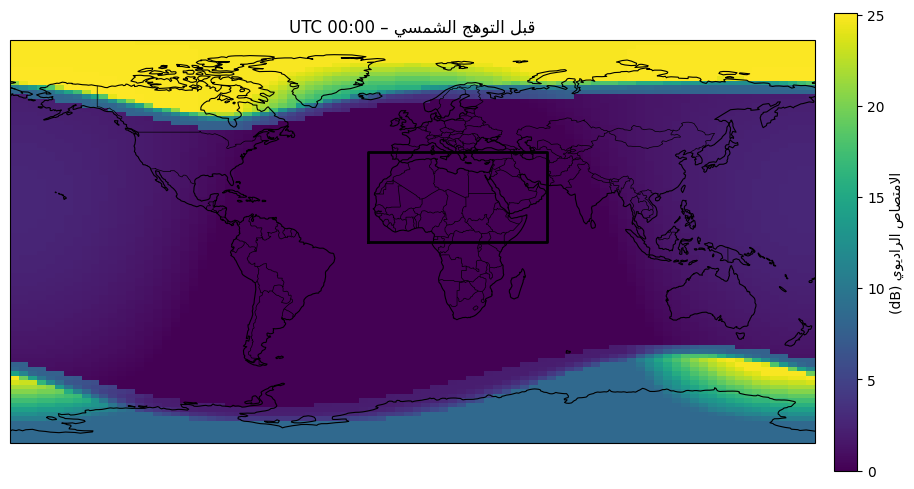

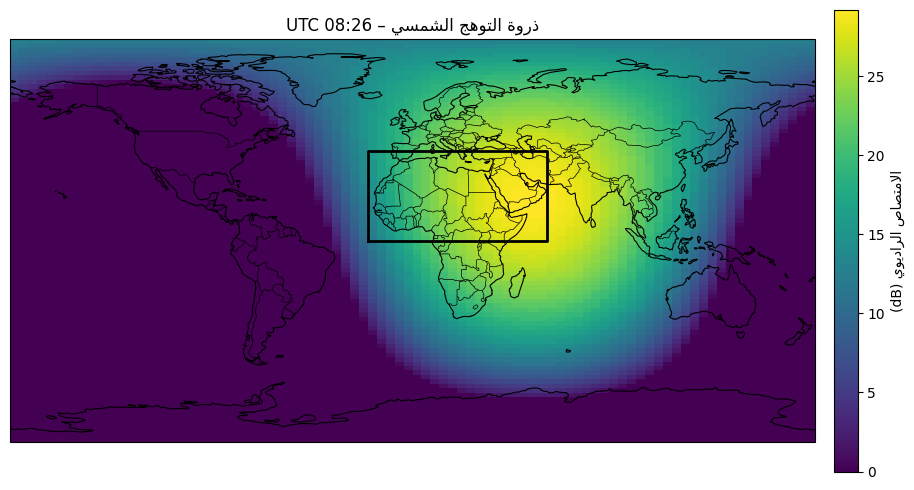

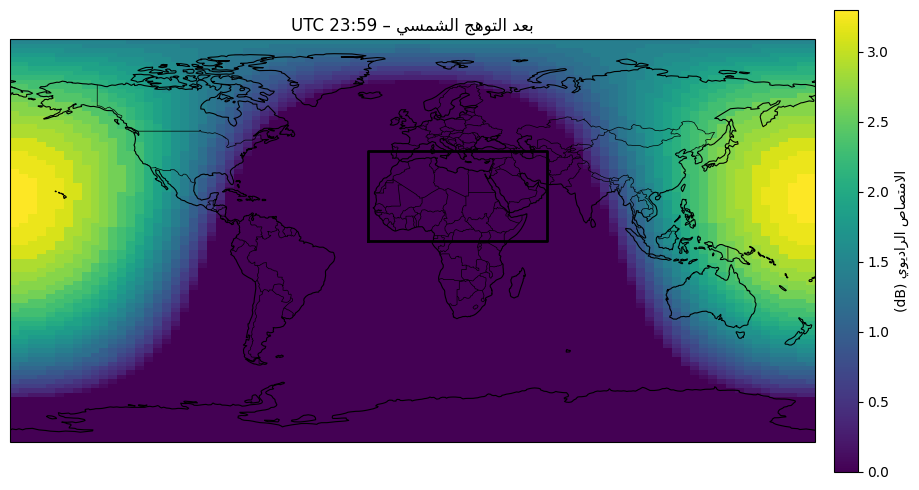

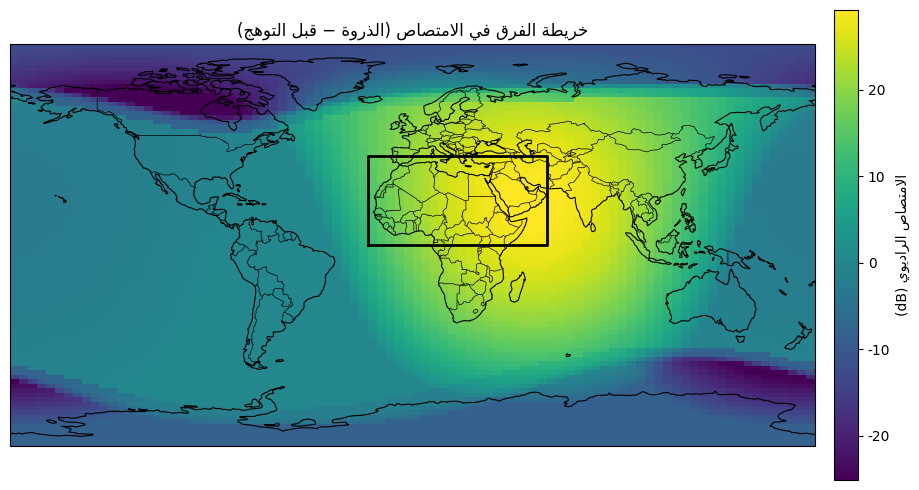

In [5]:
plot_map(*records[pre_time],
         f"قبل التوهج الشمسي – {pre_time.strftime('%H:%M UTC')}")

plot_map(*records[peak_time],
         f"ذروة التوهج الشمسي – {peak_time.strftime('%H:%M UTC')}")

plot_map(*records[post_time],
         f"بعد التوهج الشمسي – {post_time.strftime('%H:%M UTC')}")


#  خريطة الفرق (ذروة – قبل)
lats, lons, g_pre  = records[pre_time]
_,    _,    g_peak = records[peak_time]

diff = g_peak - g_pre

plot_map(
    lats, lons, diff,
    "خريطة الفرق في الامتصاص (الذروة − قبل التوهج)"
)


In [6]:
#  قراءة جميع الملفات (نسخة مصححة)
files = sorted(glob.glob(FILE_GLOB))
records = {}
series = []

for f in files:
    t, lats, lons, grid = parse_drap_txt(f)
    agrid = subset_region(lats, lons, grid)

    series.append({
        "time": t,
        "mean": np.nanmean(agrid),
        "max": np.nanmax(agrid)
    })

    # تخزين منظم (robust)
    records[t] = {
        "lats": lats,
        "lons": lons,
        "grid": grid
    }

df = pd.DataFrame(series).sort_values("time").reset_index(drop=True)


In [7]:


def plot_global_map(lats, lons, grid, title, arab_box=True):
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection=proj)

    Lon, Lat = np.meshgrid(lons, lats)

    im = ax.pcolormesh(
        Lon, Lat, grid,
        transform=proj,
        shading="auto"
    )

    # حدود العالم
    ax.coastlines(resolution="110m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # صندوق المنطقة العربية
    if arab_box:
        ax.plot(
            [ARAB_LON_MIN, ARAB_LON_MAX, ARAB_LON_MAX, ARAB_LON_MIN, ARAB_LON_MIN],
            [ARAB_LAT_MIN, ARAB_LAT_MIN, ARAB_LAT_MAX, ARAB_LAT_MAX, ARAB_LAT_MIN],
            transform=proj,
            color="black",
            linewidth=2,
            label=ar("المنطقة العربية")
        )

    ax.set_title(ar(title))
    ax.set_xlabel(ar("خط الطول"))
    ax.set_ylabel(ar("خط العرض"))

    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label(ar("الامتصاص الراديوي (dB)"))

    plt.tight_layout()
    plt.show()


In [8]:

#  قراءة ملف DRAP النصي
def parse_drap_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()

    meta = {}
    valid_time = None

    for ln in lines[:80]:
        if "Product Valid At" in ln:
            m = re.search(r"(\d{4}-\d{2}-\d{2})\s+(\d{2}:\d{2})", ln)
            if m:
                valid_time = dt.datetime.strptime(
                    f"{m.group(1)} {m.group(2)}", "%Y-%m-%d %H:%M"
                ).replace(tzinfo=dt.timezone.utc)

        if "X-RAY Message" in ln:
            meta["xray_message"] = ln.split(":", 1)[-1].strip()
        if "Proton Message" in ln:
            meta["proton_message"] = ln.split(":", 1)[-1].strip()

    if valid_time is None:
        raise ValueError("لم يتم العثور على وقت الصلاحية")

    lon_idx = None
    for i, ln in enumerate(lines):
        if re.match(r"^\s*-?\d+\s+-?\d+", ln) and len(ln.split()) > 20:
            lon_idx = i
            break

    lons = np.array(lines[lon_idx].split(), float)

    data_start = None
    for i in range(lon_idx + 1, len(lines)):
        if re.match(r"^\s*-?\d+\s*\|", lines[i]):
            data_start = i
            break

    lats, grid = [], []
    for ln in lines[data_start:]:
        if not re.match(r"^\s*-?\d+\s*\|", ln):
            continue
        lat, vals = ln.split("|", 1)
        lats.append(float(lat))
        grid.append([float(v) for v in vals.split()])

    lats = np.array(lats)
    grid = np.array(grid)

    order = np.argsort(lats)
    return valid_time, lats[order], lons, grid[order], meta


def subset_region(lats, lons, grid):
    lat_mask = (lats >= ARAB_LAT_MIN) & (lats <= ARAB_LAT_MAX)
    lon_mask = (lons >= ARAB_LON_MIN) & (lons <= ARAB_LON_MAX)
    return grid[np.ix_(lat_mask, lon_mask)]




# قراءة جميع الملفات
files = sorted(glob.glob(FILE_GLOB))
records = {}
series = []

for f in files:
    t, lats, lons, grid, meta = parse_drap_txt(f)
    agrid = subset_region(lats, lons, grid)

    series.append({
        "time": t,
        "mean": np.nanmean(agrid),
        "max": np.nanmax(agrid)
    })

    records[t] = (lats, lons, grid, meta)

df = pd.DataFrame(series).sort_values("time").reset_index(drop=True)






# اختيار الأزمنة (قبل / ذروة / بعد)
peak_time = df.loc[df["mean"].idxmax(), "time"]
pre_time  = df.iloc[0]["time"]
post_time = df.iloc[-1]["time"]




#  دالة رسم خرائط NOAA-style 
def plot_map_noaa_style(lats, lons, grid, title_ar, valid_time=None, meta=None):
    if meta is None:
        meta = {}

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(11,4.6), facecolor="black")
    ax  = plt.axes(projection=proj, facecolor="black")
    ax.set_global()

    Lon, Lat = np.meshgrid(lons, lats)

    im = ax.pcolormesh(
        Lon, Lat, grid,
        transform=proj,
        shading="auto",
        cmap="turbo"
    )

    ax.coastlines(resolution="110m", color="white", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor="white", linewidth=0.4)

    ax.set_xticks([])
    ax.set_yticks([])

    # إطار آمن متوافق مع كل إصدارات Cartopy
    for spine in ax.spines.values():
        spine.set_edgecolor("white")
        spine.set_linewidth(0.8)

    # صندوق المنطقة العربية
    ax.plot(
        [ARAB_LON_MIN, ARAB_LON_MAX, ARAB_LON_MAX, ARAB_LON_MIN, ARAB_LON_MIN],
        [ARAB_LAT_MIN, ARAB_LAT_MIN, ARAB_LAT_MAX, ARAB_LAT_MAX, ARAB_LAT_MIN],
        transform=proj,
        color="white",
        linewidth=1.6
    )

    # عنوان
    ax.text(
        0.99, 0.98, ar(title_ar),
        transform=ax.transAxes,
        ha="right", va="top",
        color="white", fontsize=12, fontweight="bold"
    )

    # Colorbar
    cax = inset_axes(ax, width="2.8%", height="78%", loc="right", borderpad=2.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(ar("الامتصاص الأقصى (dB)"), color="white")
    cbar.ax.yaxis.set_tick_params(color="white")
    plt.setp(cbar.ax.get_yticklabels(), color="white")

    # شريط معلومات سفلي
    info_ax = fig.add_axes([0.08, 0.03, 0.84, 0.17], facecolor="black")
    info_ax.set_axis_off()

    box = mpatches.FancyBboxPatch(
        (0.64, 0.18), 0.34, 0.72,
        boxstyle="round,pad=0.02",
        facecolor="#1f77b4", edgecolor="white", linewidth=0.6,
        transform=info_ax.transAxes
    )
    info_ax.add_patch(box)

    info_ax.text(0.66, 0.72, ar("حالة الأشعة السينية:"), color="white", fontsize=9, transform=info_ax.transAxes)
    info_ax.text(0.90, 0.72, ar(meta.get("xray_message", "—")), color="white", fontsize=9,
                 ha="right", transform=info_ax.transAxes)

    info_ax.text(0.66, 0.42, ar("حالة البروتونات:"), color="white", fontsize=9, transform=info_ax.transAxes)
    info_ax.text(0.90, 0.42, ar(meta.get("proton_message", "—")), color="white", fontsize=9,
                 ha="right", transform=info_ax.transAxes)

    if valid_time is not None:
        info_ax.text(
            0.00, 0.05,
            ar(f"الوقت : {valid_time.strftime('%Y-%m-%d %H:%M UTC')}"),
            color="white", fontsize=10, transform=info_ax.transAxes
        )

    info_ax.text(0.99, 0.05, "NOAA/SWPC", color="white", fontsize=10,
                 ha="right", transform=info_ax.transAxes)

    plt.show()






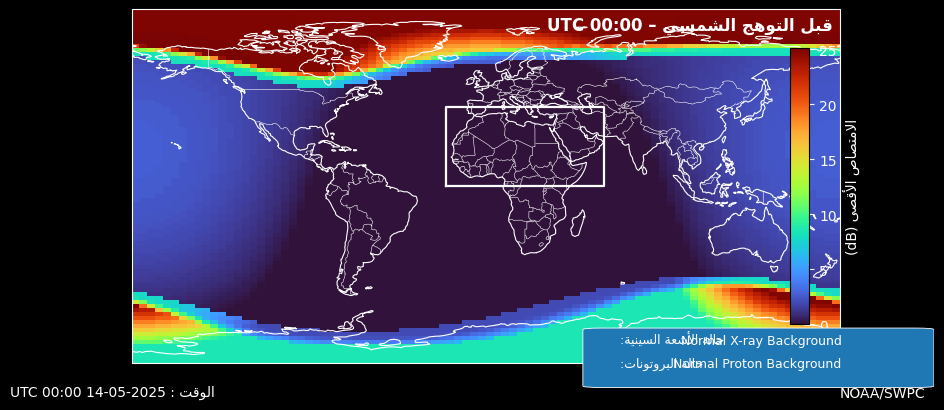

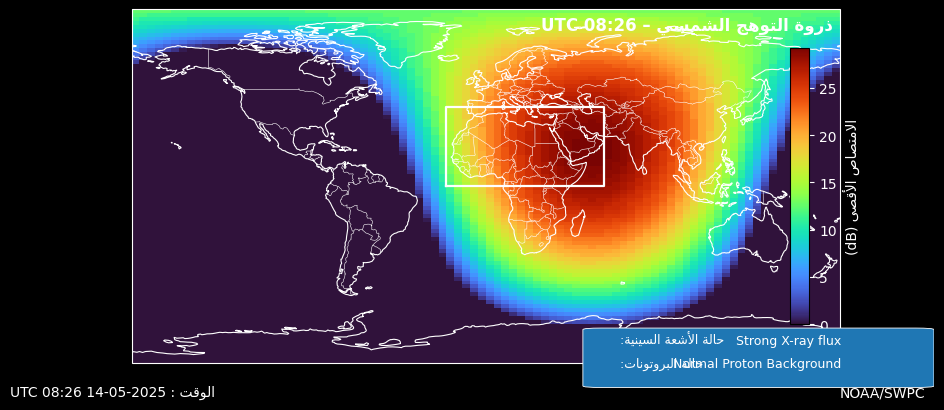

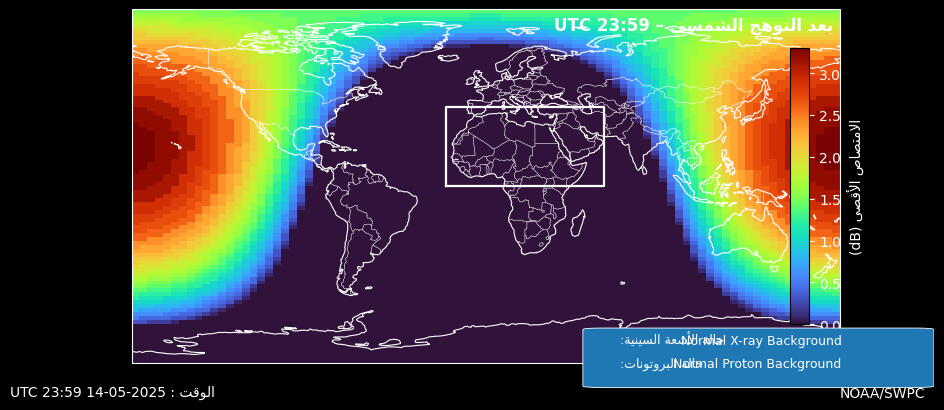

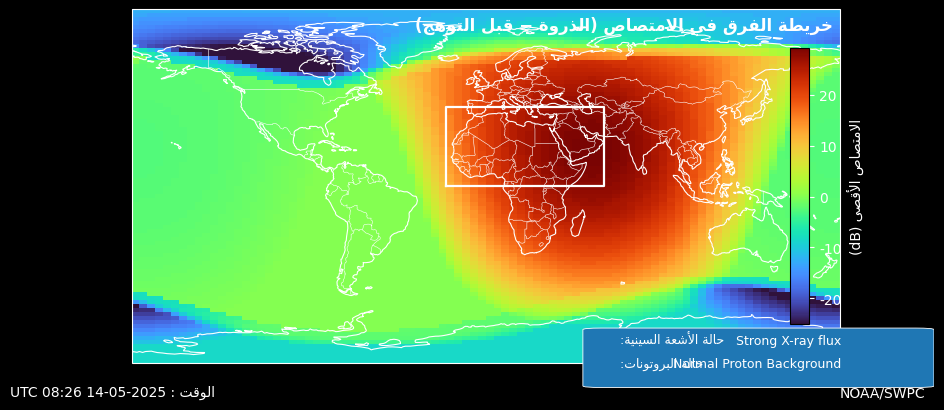

In [9]:
#  رسم الخرائط
lats_pre, lons_pre, g_pre, meta_pre = records[pre_time]
lats_pk,  lons_pk,  g_pk,  meta_pk  = records[peak_time]
lats_po,  lons_po,  g_po,  meta_po  = records[post_time]

plot_map_noaa_style(lats_pre, lons_pre, g_pre,
                    f"قبل التوهج الشمسي – {pre_time.strftime('%H:%M UTC')}",
                    valid_time=pre_time, meta=meta_pre)

plot_map_noaa_style(lats_pk, lons_pk, g_pk,
                    f"ذروة التوهج الشمسي – {peak_time.strftime('%H:%M UTC')}",
                    valid_time=peak_time, meta=meta_pk)

plot_map_noaa_style(lats_po, lons_po, g_po,
                    f"بعد التوهج الشمسي – {post_time.strftime('%H:%M UTC')}",
                    valid_time=post_time, meta=meta_po)

# خريطة الفرق
diff = g_pk - g_pre
plot_map_noaa_style(lats_pk, lons_pk, diff,
                    "خريطة الفرق في الامتصاص (الذروة − قبل التوهج)",
                    valid_time=peak_time, meta=meta_pk)


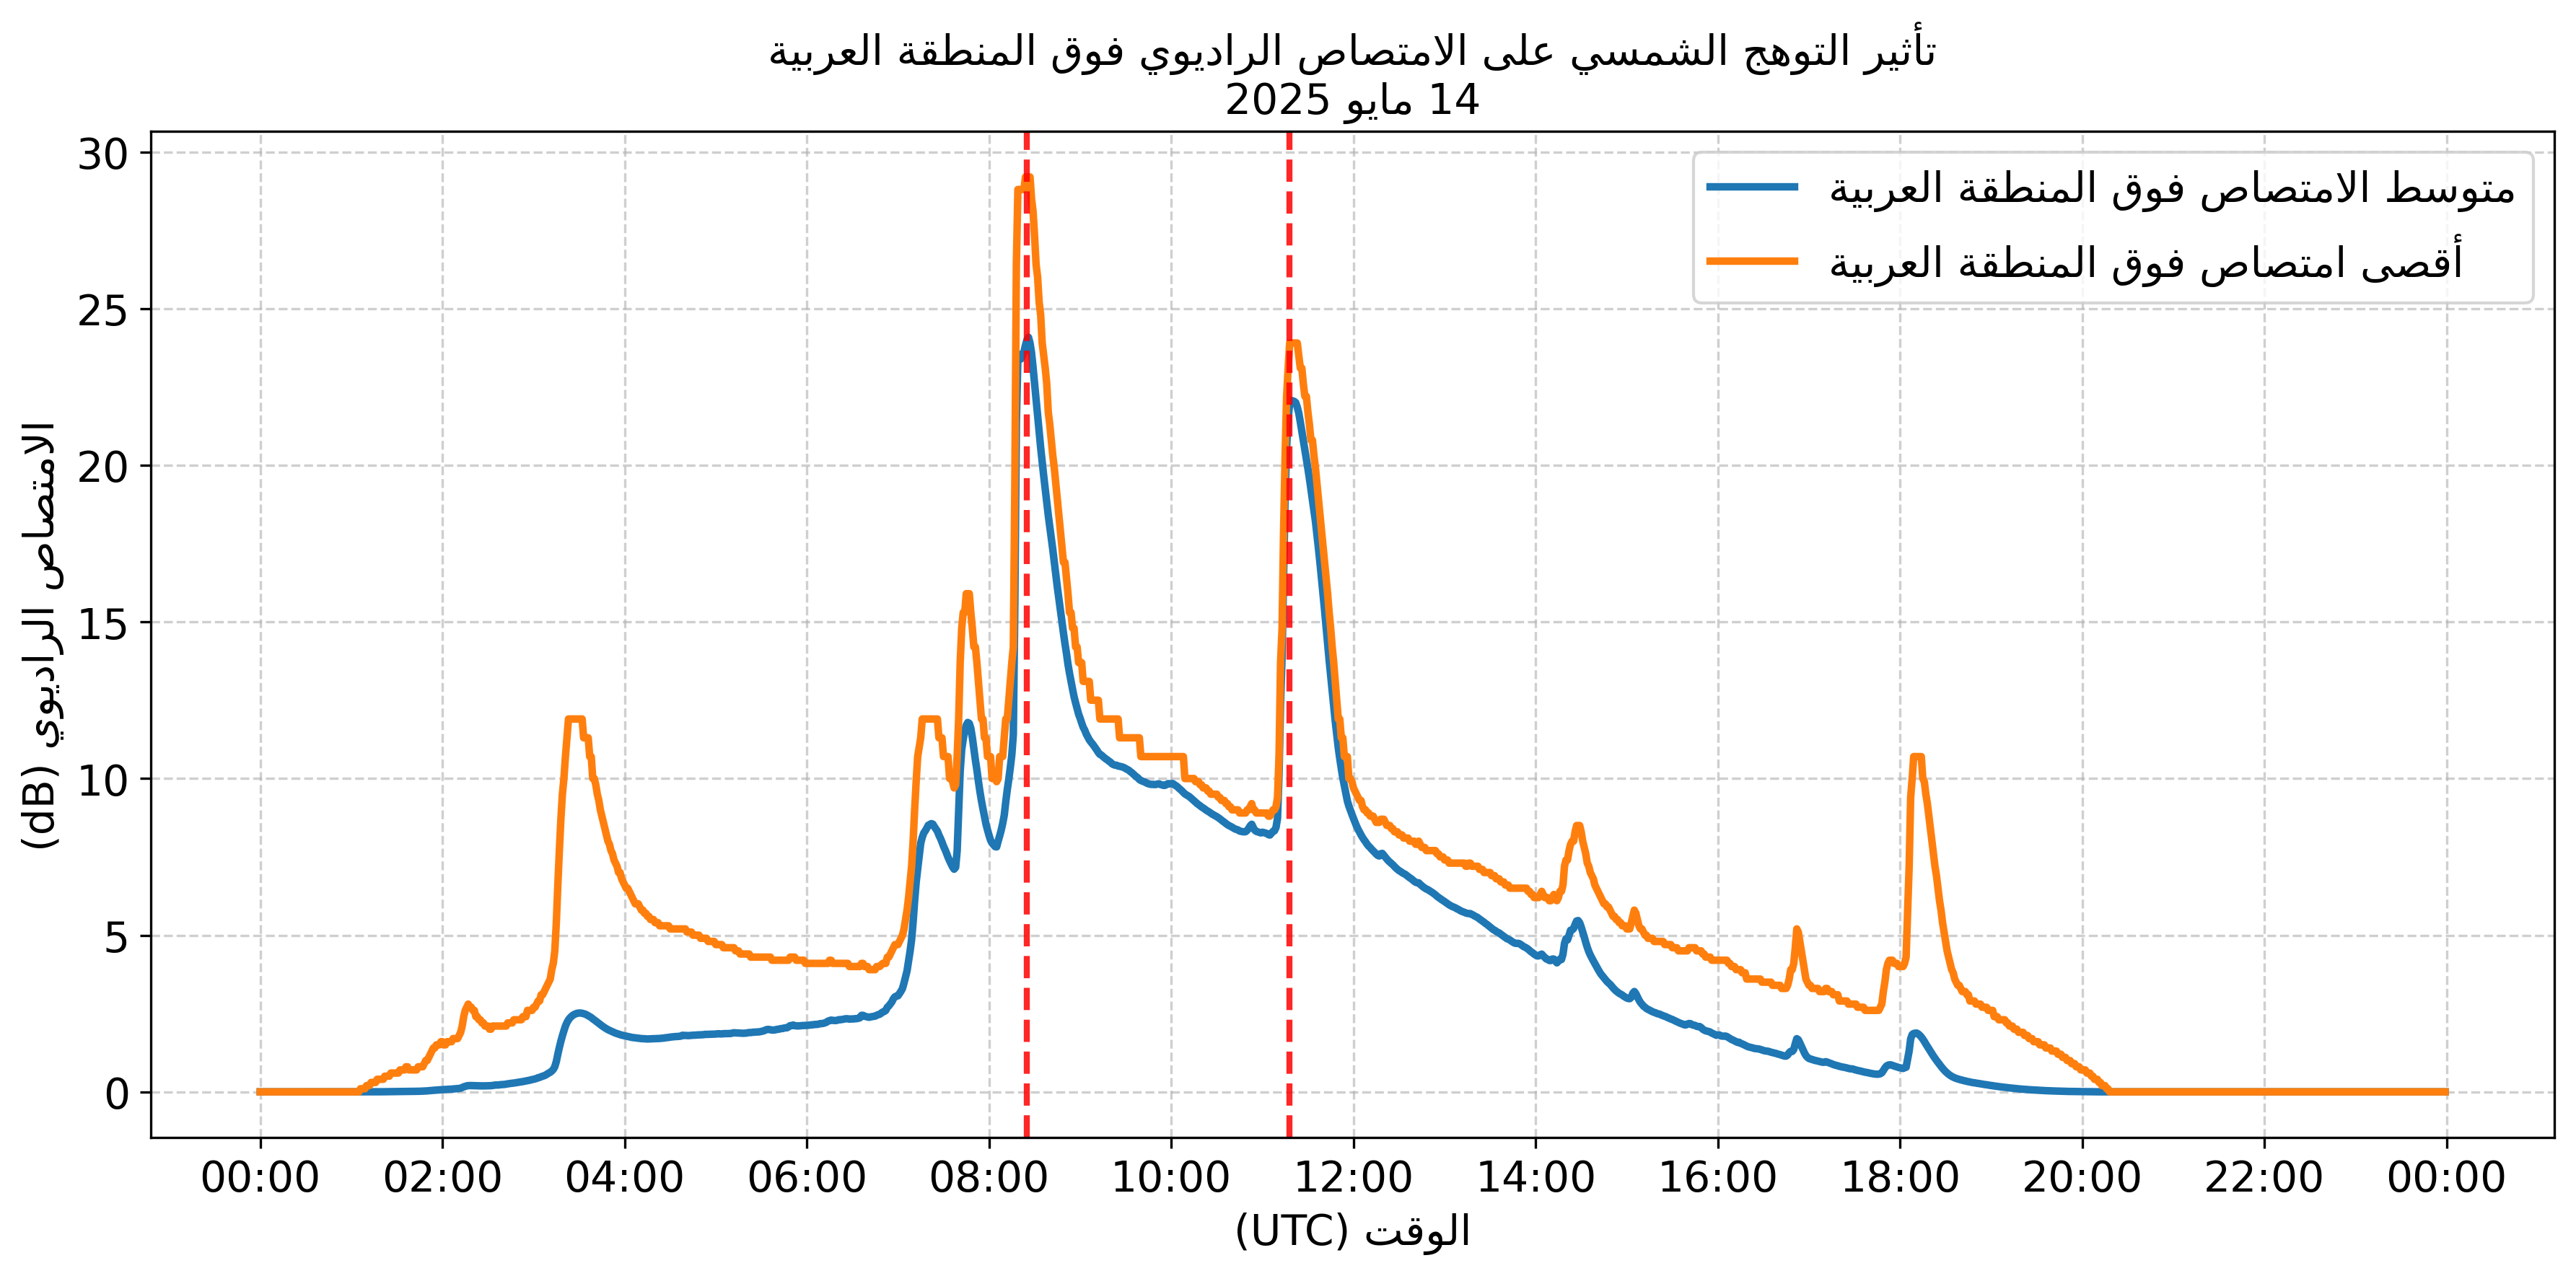

In [10]:

# السلسلة الزمنية () — مع قمم رئيسية منفصلة
plt.figure(figsize=(12, 6), dpi=300)

plt.plot(
    df["time"],
    df["mean"],
    label=ar("متوسط الامتصاص فوق المنطقة العربية"),
    linewidth=2.5
)

plt.plot(
    df["time"],
    df["max"],
    label=ar("أقصى امتصاص فوق المنطقة العربية"),
    linewidth=2.5
)



# إيجاد قمتين منفصلتين زمنيًا (من أقصى الامتصاص)
df_sorted = df.sort_values("max", ascending=False)

peak_times = []
peak_values = []

MIN_SEPARATION = pd.Timedelta(hours=1.5)  # فصل زمني 90 دقيقة

for _, row in df_sorted.iterrows():
    t = row["time"]
    if all(abs(t - pt) > MIN_SEPARATION for pt in peak_times):
        peak_times.append(t)
        peak_values.append(row["max"])
    if len(peak_times) == 2:
        break

# رسم الخطوط الرأسية للقمم
for t in peak_times:
    plt.axvline(
        t,
        color="red",
        linestyle="--",
        linewidth=2.0,
        alpha=0.85
    )




# تنسيق المحور الزمني
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

ax.tick_params(axis="x", labelsize=14, labelrotation=0)
ax.tick_params(axis="y", labelsize=14)

plt.xlabel(ar("الوقت (UTC)"), fontsize=14)
plt.ylabel(ar("الامتصاص الراديوي (dB)"), fontsize=14)

plt.title(
    ar("تأثير التوهج الشمسي على الامتصاص الراديوي فوق المنطقة العربية\n"
       "14 مايو 2025"),
    fontsize=14
)

plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [11]:
# Print peak times and values (English)
print("Main radio absorption peak times (UTC):")

for i, (t, v) in enumerate(zip(peak_times, peak_values), start=1):
    print(
        f"Peak {i}: "
        f"{t.strftime('%H:%M')} UTC — "
        f"Maximum absorption value = {v:.2f} dB"
    )


Main radio absorption peak times (UTC):
Peak 1: 08:25 UTC — Maximum absorption value = 29.20 dB
Peak 2: 11:18 UTC — Maximum absorption value = 23.90 dB


In [12]:
#  حساب نسبة المساحة المتأثرة فوق عتبات الامتصاص 

# إنشاء أعمدة النسب داخل df
for thr in THRESHOLDS_DB:
    df[f"frac_area_gt_{thr:.1f}db"] = np.nan

# حساب النسب لكل وقت
for i, row in df.iterrows():
    t = row["time"]

    # records[t] = (lats, lons, grid, meta)
    lats, lons, grid, _meta = records[t]

    # قص المنطقة العربية
    agrid = subset_region(lats, lons, grid)

    # عدد الخلايا الصالحة داخل المنطقة
    valid = np.isfinite(agrid)
    total_cells = valid.sum()

    # إن كانت كل القيم NaN (احتياطًا)
    if total_cells == 0:
        continue

    # حساب نسبة المساحة المتأثرة لكل عتبة
    for thr in THRESHOLDS_DB:
        affected = valid & (agrid >= thr)
        df.loc[i, f"frac_area_gt_{thr:.1f}db"] = affected.sum() / total_cells




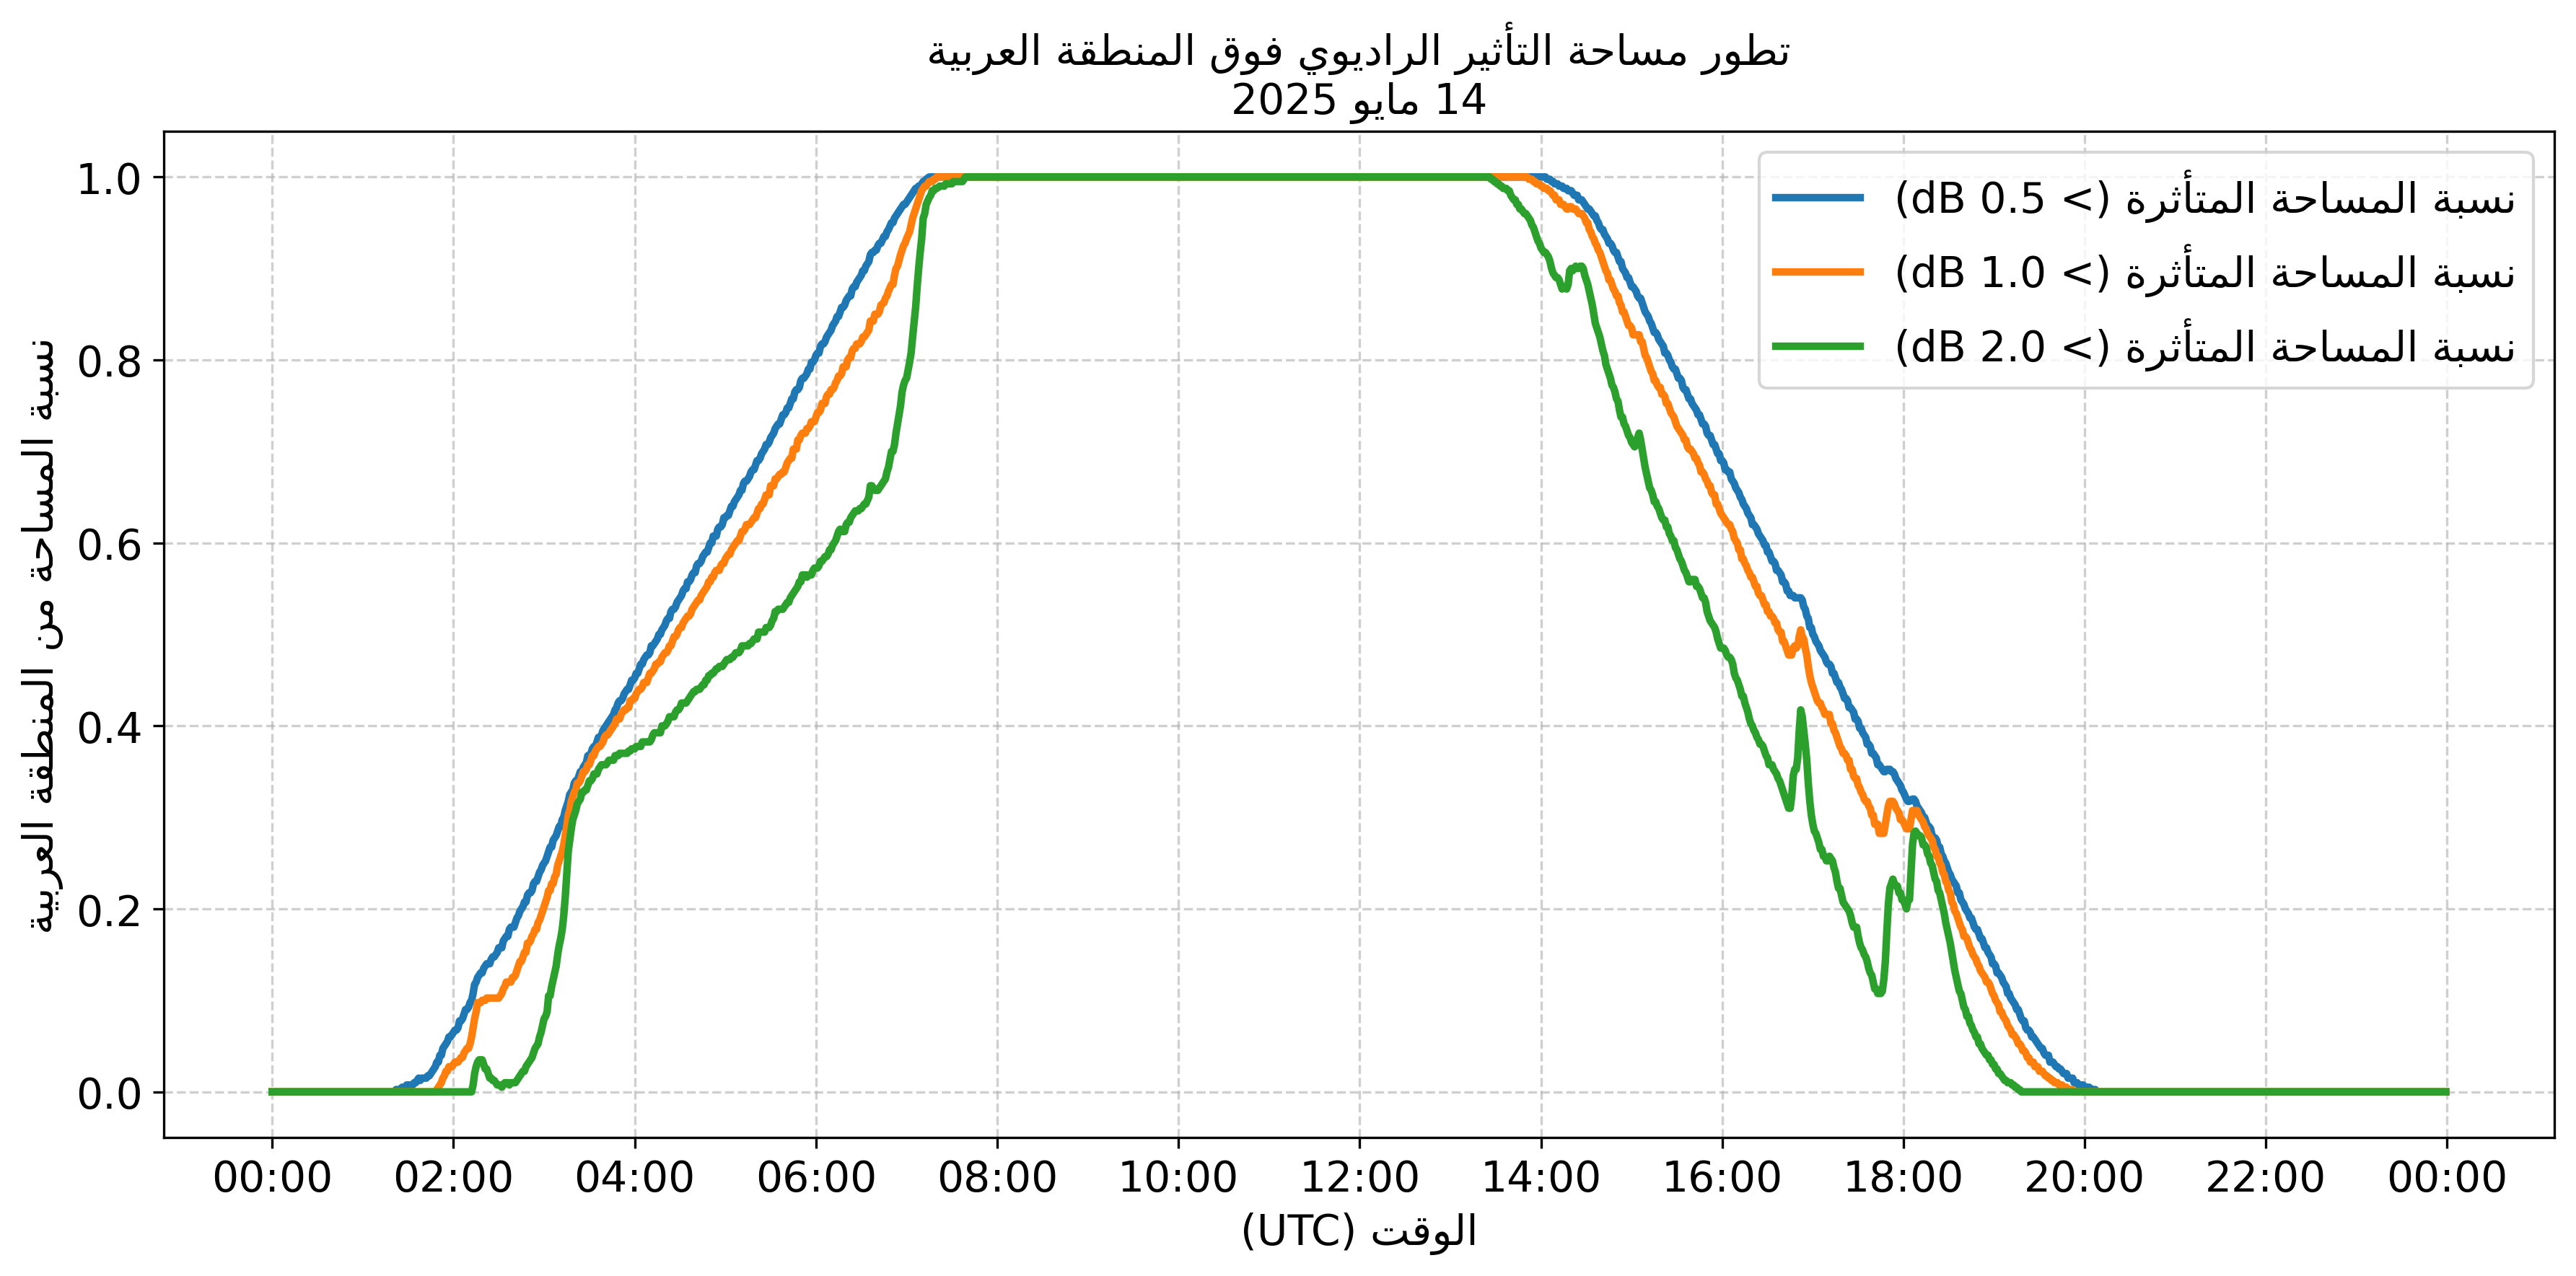

In [13]:
# ا تطور مساحة التأثير 

plt.figure(figsize=(12, 6), dpi=300)

for thr in THRESHOLDS_DB:
    plt.plot(
        df["time"],
        df[f"frac_area_gt_{thr:.1f}db"],
        linewidth=2.5,
        label=ar(f"نسبة المساحة المتأثرة (> {thr:.1f} dB)")
    )

plt.xlabel(ar("الوقت (UTC)"), fontsize=14)
plt.ylabel(ar("نسبة المساحة من المنطقة العربية"), fontsize=14)
plt.title(
    ar("تطور مساحة التأثير الراديوي فوق المنطقة العربية\n"
       "14 مايو 2025"), fontsize=14
)

plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", alpha=0.6)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()
